In [2]:
# Load required libraries
library(readr)
library(dplyr)
library(ggplot2)

# Load configuration
source("config.R")

cat("Libraries loaded successfully!\n")
cat(paste("Working directory:", getwd(), "\n"))
cat("\nConfiguration loaded:\n")
cat(paste("  - Data directory:", DATA_DIR, "\n"))
cat(paste("  - Results directory:", RESULTS_DIR, "\n"))
cat(paste("  - Padj threshold:", PADJ_THRESHOLD, "\n"))
cat(paste("  - Log2FC threshold:", LOG2FC_THRESHOLD, "\n"))


Libraries loaded successfully!
Working directory: /Users/jaisonjain/del/bulkseq 

Configuration loaded:
  - Data directory: data 
  - Results directory: results 
  - Padj threshold: 0.05 
  - Log2FC threshold: 1 


In [3]:
# Load differential expression results
# Results include: gene_id, baseMean, log2FoldChange, lfcSE, stat, pvalue, padj
cat("Loading differential expression results...\n")

de_results <- read_csv(DE_RESULTS_FILE, show_col_types = FALSE)

# Display basic statistics
cat("\nBasic statistics:\n")
cat(sprintf("  Total genes tested: %d\n", sum(!is.na(de_results$padj))))
cat(sprintf("  Significant genes (padj < %.2f): %d\n", 
            PADJ_THRESHOLD,
            sum(de_results$padj < PADJ_THRESHOLD, na.rm = TRUE)))

# Top 10 most significant genes
cat("\nTop 10 most significant genes:\n")
top_genes <- de_results %>%
  filter(!is.na(padj)) %>%
  arrange(padj) %>%
  head(10) %>%
  select(gene_id, log2FoldChange, padj)

print(top_genes)


Loading differential expression results...

Basic statistics:
  Total genes tested: 7886
  Significant genes (padj < 0.05): 940

Top 10 most significant genes:
# A tibble: 10 x 3
   gene_id   log2FoldChange     padj
   <chr>              <dbl>    <dbl>
 1 GENE02431           7.53 1.23e-85
 2 GENE08245           6.24 1.12e-79
 3 GENE03345           7.59 1.31e-73
 4 GENE05522           7.01 4.78e-72
 5 GENE09667           5.52 1.17e-57
 6 GENE08937           6.44 3.34e-52
 7 GENE08332           6.15 2.48e-50
 8 GENE08331           5.31 7.62e-49
 9 GENE04447          -5.68 5.27e-46
10 GENE09612           5.83 5.29e-42


In [4]:
# Identify genes with largest fold changes
cat("\nGenes with largest fold changes...\n")

# Top 5 upregulated genes
cat("\nTop 5 upregulated genes:\n")
top_up <- de_results %>%
  filter(!is.na(padj), padj < PADJ_THRESHOLD) %>%
  arrange(desc(log2FoldChange)) %>%
  head(5) %>%
  select(gene_id, log2FoldChange, padj)

print(top_up)

# Top 5 downregulated genes
cat("\nTop 5 downregulated genes:\n")
top_down <- de_results %>%
  filter(!is.na(padj), padj < PADJ_THRESHOLD) %>%
  arrange(log2FoldChange) %>%
  head(5) %>%
  select(gene_id, log2FoldChange, padj)

print(top_down)



Genes with largest fold changes...

Top 5 upregulated genes:
# A tibble: 5 x 3
  gene_id   log2FoldChange     padj
  <chr>              <dbl>    <dbl>
1 GENE06414           7.95 2.63e-15
2 GENE03345           7.59 1.31e-73
3 GENE02431           7.53 1.23e-85
4 GENE00349           7.23 1.57e-12
5 GENE04342           7.12 4.23e-33

Top 5 downregulated genes:
# A tibble: 5 x 3
  gene_id   log2FoldChange     padj
  <chr>              <dbl>    <dbl>
1 GENE09641          -8.49 7.58e-19
2 GENE02868          -8.21 3.34e-16
3 GENE07132          -7.96 3.43e-14
4 GENE08633          -7.34 5.38e-13
5 GENE01248          -6.86 3.77e-10


In [5]:
# Filter genes by custom criteria
cat("\nCustom filtering examples...\n")

# Example 1: Highly upregulated genes
highly_upregulated <- de_results %>%
  filter(!is.na(padj),
         padj < 0.01,
         log2FoldChange > 2)

cat(sprintf("\nGenes with padj < 0.01 and log2FC > 2: %d\n", 
            nrow(highly_upregulated)))

# Example 2: Moderately expressed and significant
moderate_de <- de_results %>%
  filter(!is.na(padj),
         padj < PADJ_THRESHOLD,
         baseMean > 100,
         baseMean < 1000,
         abs(log2FoldChange) > 1)

cat(sprintf("Moderately expressed DE genes (100 < baseMean < 1000): %d\n",
            nrow(moderate_de)))



Custom filtering examples...

Genes with padj < 0.01 and log2FC > 2: 418
Moderately expressed DE genes (100 < baseMean < 1000): 205


In [6]:
# Compare with ground truth (if available)
truth_file <- file.path(DATA_DIR, "ground_truth.csv")

if (file.exists(truth_file)) {
  cat("\nComparing with ground truth...\n")
  
  truth <- read_csv(truth_file, show_col_types = FALSE)
  
  comparison <- de_results %>%
    left_join(truth, by = "gene_id") %>%
    filter(!is.na(padj))
  
  # Calculate accuracy metrics
  tp <- sum(comparison$true_DE & 
            comparison$padj < PADJ_THRESHOLD & 
            abs(comparison$log2FoldChange) > LOG2FC_THRESHOLD)
  fp <- sum(!comparison$true_DE & 
            comparison$padj < PADJ_THRESHOLD & 
            abs(comparison$log2FoldChange) > LOG2FC_THRESHOLD)
  fn <- sum(comparison$true_DE & 
            (comparison$padj >= PADJ_THRESHOLD | 
             abs(comparison$log2FoldChange) <= LOG2FC_THRESHOLD))
  tn <- sum(!comparison$true_DE & 
            (comparison$padj >= PADJ_THRESHOLD | 
             abs(comparison$log2FoldChange) <= LOG2FC_THRESHOLD))
  
  accuracy <- (tp + tn) / (tp + tn + fp + fn)
  sensitivity <- tp / (tp + fn)
  specificity <- tn / (tn + fp)
  precision <- tp / (tp + fp)
  f1_score <- 2 * (precision * sensitivity) / (precision + sensitivity)
  
  cat(sprintf("\nPerformance metrics:\n"))
  cat(sprintf("  Accuracy:    %.3f\n", accuracy))
  cat(sprintf("  Sensitivity: %.3f (recall, TPR)\n", sensitivity))
  cat(sprintf("  Specificity: %.3f (TNR)\n", specificity))
  cat(sprintf("  Precision:   %.3f (PPV)\n", precision))
  cat(sprintf("  F1-score:    %.3f\n", f1_score))
} else {
  cat("\nNo ground truth file found. Skipping validation.\n")
}



Comparing with ground truth...

Performance metrics:
  Accuracy:    0.945
  Sensitivity: 0.706 (recall, TPR)
  Specificity: 0.990 (TNR)
  Precision:   0.928 (PPV)
  F1-score:    0.801



Correlation of true vs estimated log2FC: 0.971

Saved fold change comparison plot: results/plots/fc_comparison.pdf


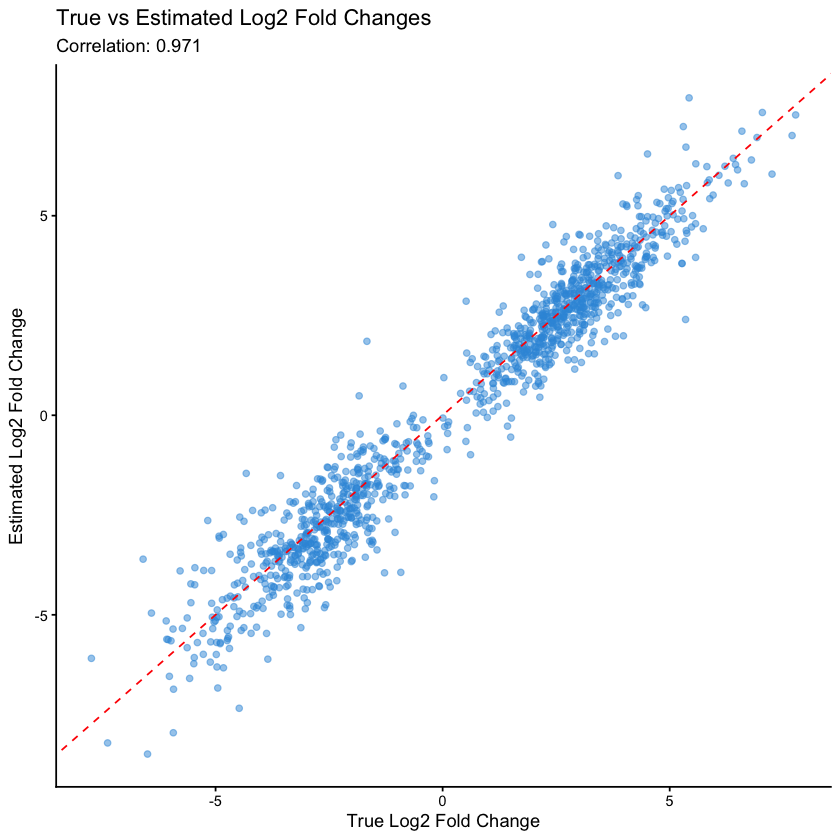

In [7]:
# Visualize comparison of true vs estimated fold changes
truth_file <- file.path(DATA_DIR, "ground_truth.csv")

if (file.exists(truth_file)) {
  truth <- read_csv(truth_file, show_col_types = FALSE)
  
  comparison_plot_data <- de_results %>%
    left_join(truth, by = "gene_id") %>%
    filter(!is.na(padj)) %>%
    mutate(
      result = case_when(
        true_DE & padj < PADJ_THRESHOLD & abs(log2FoldChange) > LOG2FC_THRESHOLD ~ "True Positive",
        !true_DE & padj < PADJ_THRESHOLD & abs(log2FoldChange) > LOG2FC_THRESHOLD ~ "False Positive",
        true_DE & (padj >= PADJ_THRESHOLD | abs(log2FoldChange) <= LOG2FC_THRESHOLD) ~ "False Negative",
        TRUE ~ "True Negative"
      )
    )
  
  # Correlation of fold changes for true DE genes
  fc_comparison <- comparison_plot_data %>%
    filter(true_DE)
  
  if (nrow(fc_comparison) > 0) {
    fc_cor <- cor(fc_comparison$true_log2FC, fc_comparison$log2FoldChange, 
                  use = "complete.obs")
    
    cat(sprintf("\nCorrelation of true vs estimated log2FC: %.3f\n", fc_cor))
    
    # Create comparison plot
    p_comparison <- ggplot(fc_comparison, 
                          aes(x = true_log2FC, y = log2FoldChange)) +
      geom_point(alpha = 0.5, color = "#3498db") +
      geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
      theme_classic() +
      labs(title = "True vs Estimated Log2 Fold Changes",
           subtitle = sprintf("Correlation: %.3f", fc_cor),
           x = "True Log2 Fold Change",
           y = "Estimated Log2 Fold Change")
    
    print(p_comparison)
    
    ggsave(file.path(PLOTS_DIR, "fc_comparison.pdf"), p_comparison,
           width = 6, height = 6)
    cat(sprintf("\nSaved fold change comparison plot: %s\n", 
                file.path(PLOTS_DIR, "fc_comparison.pdf")))
  }
}


In [8]:
# Export custom gene lists for downstream analysis
cat("\nCreating custom gene lists...\n")

# Create output directory for gene lists
genelist_dir <- file.path(RESULTS_DIR, "gene_lists")
if (!dir.exists(genelist_dir)) {
  dir.create(genelist_dir, recursive = TRUE)
}

# Export different gene categories
categories <- list(
  "all_significant" = de_results %>%
    filter(!is.na(padj), padj < PADJ_THRESHOLD, 
           abs(log2FoldChange) > LOG2FC_THRESHOLD),
  
  "upregulated" = de_results %>%
    filter(!is.na(padj), padj < PADJ_THRESHOLD, 
           log2FoldChange > LOG2FC_THRESHOLD),
  
  "downregulated" = de_results %>%
    filter(!is.na(padj), padj < PADJ_THRESHOLD, 
           log2FoldChange < -LOG2FC_THRESHOLD),
  
  "highly_significant" = de_results %>%
    filter(!is.na(padj), padj < 0.001, 
           abs(log2FoldChange) > LOG2FC_THRESHOLD)
)

for (name in names(categories)) {
  gene_list <- categories[[name]]
  if (nrow(gene_list) > 0) {
    filename <- file.path(genelist_dir, paste0(name, "_genes.csv"))
    write_csv(gene_list, filename)
    cat(sprintf("  Exported %s: %d genes -> %s\n", 
                name, nrow(gene_list), filename))
    
    # Also save just gene IDs (useful for other tools)
    id_filename <- file.path(genelist_dir, paste0(name, "_ids.txt"))
    writeLines(gene_list$gene_id, id_filename)
  }
}



Creating custom gene lists...
  Exported all_significant: 938 genes -> results/gene_lists/all_significant_genes.csv
  Exported upregulated: 537 genes -> results/gene_lists/upregulated_genes.csv
  Exported downregulated: 401 genes -> results/gene_lists/downregulated_genes.csv
  Exported highly_significant: 645 genes -> results/gene_lists/highly_significant_genes.csv



DE statistics by expression level...

DE genes by expression level:
# A tibble: 4 x 4
  expression_bin    total significant prop_sig
  <fct>             <int>       <int>    <dbl>
1 Low (0-10)         3701         259   0.0700
2 Medium (10-100)    3023         410   0.136 
3 High (100-1000)    1001         205   0.205 
4 Very High (>1000)   161          64   0.398 


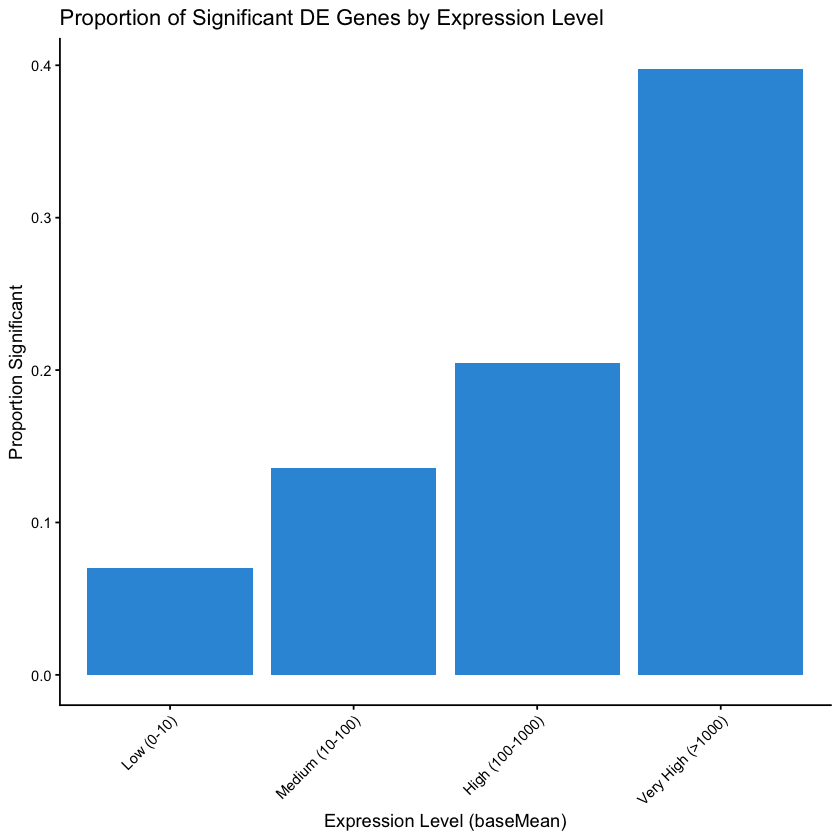

In [9]:
# Analyze DE statistics by expression level
cat("\nDE statistics by expression level...\n")

de_by_expression <- de_results %>%
  filter(!is.na(padj)) %>%
  mutate(
    expression_bin = cut(baseMean, 
                        breaks = c(0, 10, 100, 1000, Inf),
                        labels = c("Low (0-10)", "Medium (10-100)", 
                                  "High (100-1000)", "Very High (>1000)")),
    significant = padj < PADJ_THRESHOLD & abs(log2FoldChange) > LOG2FC_THRESHOLD
  ) %>%
  group_by(expression_bin) %>%
  summarise(
    total = n(),
    significant = sum(significant),
    prop_sig = significant / total,
    .groups = "drop"
  )

cat("\nDE genes by expression level:\n")
print(de_by_expression)

# Visualize DE statistics by expression level
p_exp_level <- ggplot(de_by_expression, aes(x = expression_bin, y = prop_sig)) +
  geom_bar(stat = "identity", fill = "#3498db") +
  theme_classic() +
  labs(title = "Proportion of Significant DE Genes by Expression Level",
       x = "Expression Level (baseMean)",
       y = "Proportion Significant") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

print(p_exp_level)



Creating volcano plot...
  Upregulated: 537
  Downregulated: 401
  Not Significant: 6948


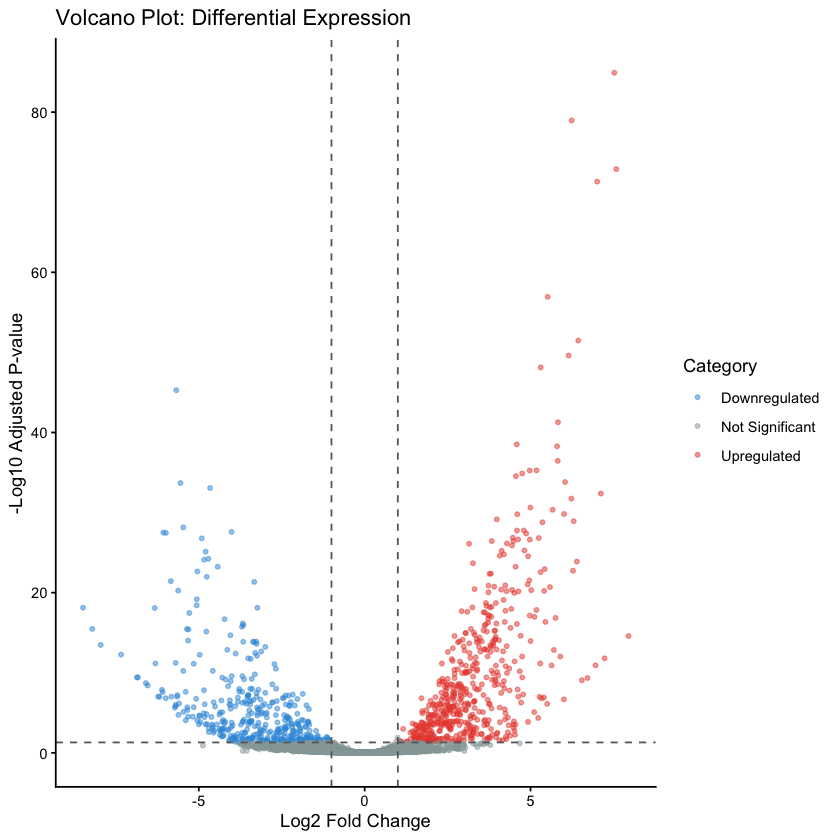

In [10]:
# Create volcano plot
cat("\nCreating volcano plot...\n")

# Prepare data for volcano plot
volcano_data <- de_results %>%
  filter(!is.na(padj)) %>%
  mutate(
    neg_log10_padj = -log10(padj),
    significance = case_when(
      padj < PADJ_THRESHOLD & log2FoldChange > LOG2FC_THRESHOLD ~ "Upregulated",
      padj < PADJ_THRESHOLD & log2FoldChange < -LOG2FC_THRESHOLD ~ "Downregulated",
      TRUE ~ "Not Significant"
    )
  )

# Count categories
cat(sprintf("  Upregulated: %d\n", sum(volcano_data$significance == "Upregulated")))
cat(sprintf("  Downregulated: %d\n", sum(volcano_data$significance == "Downregulated")))
cat(sprintf("  Not Significant: %d\n", sum(volcano_data$significance == "Not Significant")))

# Create volcano plot
p_volcano <- ggplot(volcano_data, aes(x = log2FoldChange, y = neg_log10_padj, color = significance)) +
  geom_point(alpha = 0.5, size = 1) +
  scale_color_manual(values = c("Upregulated" = "#e74c3c", 
                                "Downregulated" = "#3498db", 
                                "Not Significant" = "#95a5a6")) +
  geom_hline(yintercept = -log10(PADJ_THRESHOLD), linetype = "dashed", color = "gray40") +
  geom_vline(xintercept = c(-LOG2FC_THRESHOLD, LOG2FC_THRESHOLD), 
             linetype = "dashed", color = "gray40") +
  theme_classic() +
  labs(title = "Volcano Plot: Differential Expression",
       x = "Log2 Fold Change",
       y = "-Log10 Adjusted P-value",
       color = "Category")

print(p_volcano)



Creating MA plot...


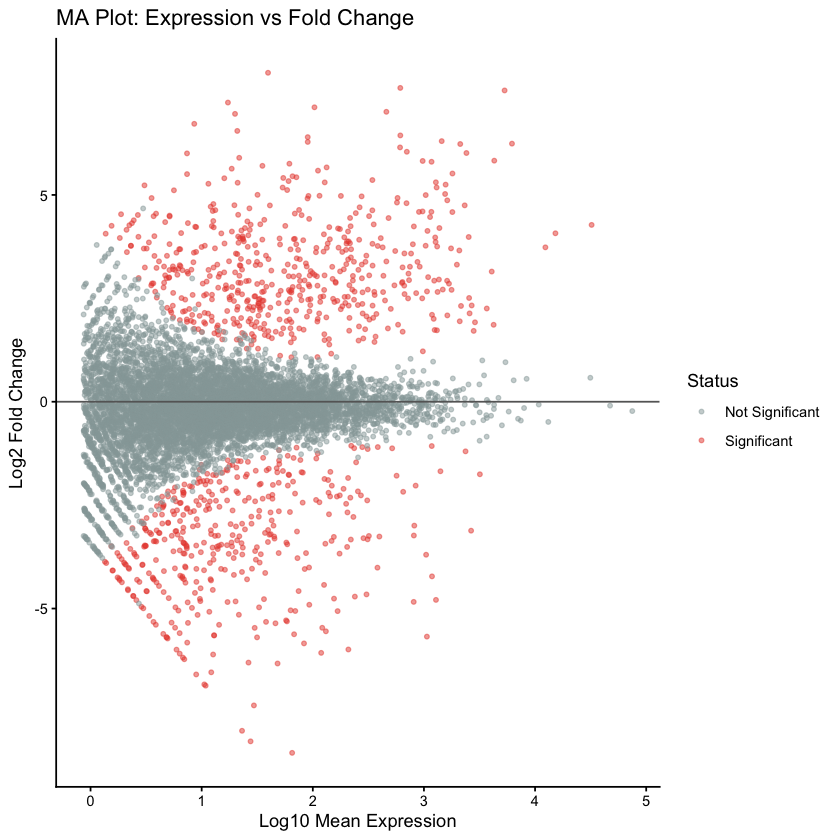

In [11]:
# Create MA plot
cat("\nCreating MA plot...\n")

ma_data <- de_results %>%
  filter(!is.na(padj), baseMean > 0) %>%
  mutate(
    log10_baseMean = log10(baseMean),
    significant = padj < PADJ_THRESHOLD & abs(log2FoldChange) > LOG2FC_THRESHOLD
  )

p_ma <- ggplot(ma_data, aes(x = log10_baseMean, y = log2FoldChange, color = significant)) +
  geom_point(alpha = 0.5, size = 1) +
  scale_color_manual(values = c("FALSE" = "#95a5a6", "TRUE" = "#e74c3c"),
                    labels = c("Not Significant", "Significant")) +
  geom_hline(yintercept = 0, linetype = "solid", color = "gray40") +
  theme_classic() +
  labs(title = "MA Plot: Expression vs Fold Change",
       x = "Log10 Mean Expression",
       y = "Log2 Fold Change",
       color = "Status")

print(p_ma)


In [12]:
# Summary
cat("\n============================================\n")
cat("Example analysis complete!\n")
cat("\nAdditional analyses you can perform:\n")
cat("  - Cluster genes by expression patterns\n")
cat("  - Compare multiple contrasts\n")
cat("  - Time-series analysis (if applicable)\n")
cat("  - Integration with other omics data\n")
cat("  - Custom pathway analysis\n")
cat("\nFor more information, consult:\n")
cat("  - DESeq2 vignette: browseVignettes('DESeq2')\n")
cat("  - clusterProfiler book: https://yulab-smu.top/biomedical-knowledge-mining-book/\n")
cat("============================================\n\n")



Example analysis complete!

Additional analyses you can perform:
  - Cluster genes by expression patterns
  - Compare multiple contrasts
  - Time-series analysis (if applicable)
  - Integration with other omics data
  - Custom pathway analysis

For more information, consult:
  - DESeq2 vignette: browseVignettes('DESeq2')
  - clusterProfiler book: https://yulab-smu.top/biomedical-knowledge-mining-book/

